## Settings
> Set the path to the txt file of target corpus.

In [2]:
import sys
sys.path.append('../')

In [2]:
# each line is a correct sentence text.
PATH_TO_CORPUS = "/data/chendian/bbcm_datasets/bbcm_corpus.txt"
lines = [line.strip() for line in open(PATH_TO_CORPUS, 'r')]

In [3]:
from transformers import BertTokenizer    
BERT_DIR_PATH = "/data/chendian/pretrained_bert_models/chinese-macbert-base/"
tokenizer = BertTokenizer.from_pretrained(BERT_DIR_PATH)

/home/chendian/.conda/envs/bbcm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## obtain corpus from Wang271k dataset.
> take Wang271k as an example, show how to obtain a pure text corpus from csc-datasets.

In [ ]:
# extract correct sentences from `.sgml` file.
from tqdm import tqdm
from lxml import etree


dump_path = '/data/chendian/bbcm_datasets/bbcm_corpus.txt'


def proc_confusion_item_for_corpus(item, id_prefix="", id_postfix=""):
    """
    处理 confusion set 数据集 (AutoCorpusGeneration)
    Args:
        item:
    Returns:
    """
    root = etree.XML(item)
    text = root.xpath('/SENTENCE/TEXT/text()')[0]
    mistakes = []
    for mistake in root.xpath('/SENTENCE/MISTAKE'):
        mistakes.append({'location': int(mistake.xpath('./LOCATION/text()')[0]) - 1,
                         'wrong': mistake.xpath('./WRONG/text()')[0].strip(),
                         'correction': mistake.xpath('./CORRECTION/text()')[0].strip()})

    cor_text = text
    wrong_ids = []

    for mis in mistakes:
        cor_text = f'{cor_text[:mis["location"]]}{mis["correction"]}{cor_text[mis["location"] + 1:]}'
        wrong_ids.append(mis['location'])

    if len(text) == len(cor_text):
        return cor_text
    print(text)
    print(cor_text)
    print(len(text), len(cor_text))
    raise ValueError()
    return None


def read_confusion_data(fp):
    # read AutoCorpusGeneration corpus released from the EMNLP2018 paper
    with open(fp, 'r', encoding='utf8') as f:
        item = []
        for line in tqdm(f):
            if line.strip().startswith('<SENT') and len(item) > 0:
                yield ''.join(item)
                item = [line.strip()]
            elif line.strip().startswith('<'):
                item.append(line.strip())


def extract_wang271k_lines():
    file_path = '/home/chendian/BBCM/datasets/csc/train.sgml'
    # convertor = opencc.OpenCC('tw2sp.json')

    confusion_samples = [proc_confusion_item_for_corpus(item, id_prefix='cf', id_postfix=str(_i))
                         for _i, item in enumerate(read_confusion_data(file_path))]
    with open(dump_path, 'w') as f:
        for sample in tqdm(confusion_samples):
            if sample is None:
                continue
            f.write(f'{sample}\n')   


extract_wang271k_lines()

In [ ]:
# BBCM corpus
import pypinyin
from tqdm import tqdm


dump_path = '/data/chendian/bbcm_datasets/bbcm_corpus.txt'


def mark_unk_wang271k_corpus():
    # tokenizer = BertTokenizer.from_pretrained("/data/chendian/pretrained_bert_models/chinese-macbert-base/")
    count = 0
    lines = [line.strip() for line in open(dump_path, 'r')]
    with open(dump_path.replace('.txt', '_badlines.txt'), 'w') as f:
        for line_idx, line in tqdm(enumerate(lines)):
            mark_flag = []
            tokens = tokenizer.tokenize(line)
            tokens = [_tok[2:] if _tok.startswith('##') else _tok for _tok in tokens]
            pinyins = pypinyin.pinyin(
                tokens, heteronym=False, style=pypinyin.NORMAL, 
                errors=lambda _x: '[PAD]' if _x in ['[PAD]', '[CLS]', '[SEP]'] else '[UNK]')
            pinyins = [_py[0] for _py in pinyins]
            if '[UNK]' in tokens:
                mark_flag.append("unk_token")
            elif sum(map(len, tokens)) != len(line):
                mark_flag.append("longer_token_length")
            if len(pinyins) != len(tokens):
                mark_flag.append("unk_pinyin")
            if len(mark_flag) > 0:
                f.write(f'{line_idx}\t{mark_flag}\t{len(line)}:{len(tokens)}t:{len(pinyins)}p\t{line}\t{tokens}\t{pinyins}\n')            
                count += 1
    print("UNK count:", count)


mark_unk_wang271k_corpus()

In [13]:
from tqdm import tqdm


src_path = '/data/chendian/bbcm_datasets/bbcm_corpus.txt'
dump_path = './tmp/wang271k_corpus.txt'
drop_lines = [int(line.strip().split('\t')[0]) 
              for line in open(src_path.replace('.txt', '_badlines.txt'), 'r')]

drop_pivot = 0
line_count = 0
with open('./tmp/wang271k_corpus.txt', 'w') as f:
    for i, line in tqdm(enumerate(open(src_path, 'r'))):
        if drop_pivot < len(drop_lines):
            if i == drop_lines[drop_pivot]:
                drop_pivot += 1
                continue
        # f.write(' '.join(jieba.lcut(line.strip())))
        f.write(f'{line.strip()}\n')
        line_count += 1


from utils.file_io import get_filesize
print(dump_path, get_filesize(dump_path), 'MB\n', line_count, 'lines')

271328it [00:00, 365596.75it/s]

32.93 MB
 269619 lines


## generate segmentation results
> 共现矩阵（150000 x sids）：生成 word_in_sentences 文件

In [4]:
from stanfordcorenlp import StanfordCoreNLP
stanford_model_path = r'/home/chendian/download/stanford-corenlp-4.2.2/'
print(f"Now loading NER model from {stanford_model_path}")

stanford_model = StanfordCoreNLP(stanford_model_path, lang='zh', quiet=True)
ner_model = stanford_model

Now loading NER model from /home/chendian/download/stanford-corenlp-4.2.2/


In [11]:
# generate masks for each line in corpus
import numpy as np
from utils import convert_to_unicode
from utils.text_utils import is_chinese_char, is_whitespace, is_control, is_punctuation


PUNC_LIST = "，；。？！…"
invalid_tags = ['PERSON', 'NUMBER']  # Location, Person, Organization, Money, Percent, Date, Time


def stanford_ner(text):
    # from urllib.parse import quote
    # fix the issue with '%' sign for StanfordNLP
    # data=quote(text),  # quote may bring length-changing issues
    r_dict = ner_model._request(
        annotators='ner', 
        data=text.replace("%", "％"))
    words = []
    ner_tags = []  # ['O', 'MISC', 'LOCATION', 'GPE', 'FACILITY', 'ORGANIZATION', 'DEMONYM', 'PERSON']
    positions = []
    for s in r_dict['sentences']:
        for token in s['tokens']:
            # "可"
            words.append(token['originalText'])
            # "O"
            ner_tags.append(token['ner'])
            # (2, 3) 
            positions.append((token['characterOffsetBegin'], 
                                token['characterOffsetEnd']))
    return list(zip(words, ner_tags, positions))


def get_valid_position_mask(text):        
    # using stanford ner's segmentation
    # a list of [original_text, ner_tag, (begin, end)]
    results = stanford_ner(text)
    
    # the mask is char-level only for augmentation, not the same with det_label's mask
    text_len = len(text)

    # init masks
    word_offsets = {}
    chn_mask = np.ones(text_len, dtype=int)
    ner_mask = np.zeros(text_len, dtype=int)

    # generate chn_mask
    for w_idx, w in enumerate(convert_to_unicode(text)):
        if is_whitespace(w) or is_control(w):
            chn_mask[w_idx] = 0
        # TODO: commas are easy to correct, maybe we can also correct them
        elif (w in PUNC_LIST) or is_punctuation(w):
            chn_mask[w_idx] = 0
        elif not is_chinese_char(ord(w)):
            chn_mask[w_idx] = 0
    
    # generate word_offsets and ner_mask
    valid_flag = True
    if results[-1][-1][-1] > text_len:  # the last word's position's ending_pos
        print("Detected an invalid text:", text)
        valid_flag = False
    for w_idx, (w, tag, position) in enumerate(results):
        tokens_in_word = list(range(position[0], position[1]))  # (l, r) from stanfordNLP
        word_offsets.update(
            {token: tokens_in_word for token in tokens_in_word})
        # cur_chn_mask = [1 if is_chinese_char(ord(token)) else 0 for token in convert_to_unicode(w)]
        # if (position[1] - position[0]) == len(w) == len(cur_chn_mask):
        #     chn_mask[position[0]: position[1]] = cur_chn_mask
        # else:
        #     print(w, tag, position, 
        #           (position[1] - position[0], len(w), len(cur_chn_mask)))
        #     print(f"Unaligned length between word <{w}> and chn_mask <{cur_chn_mask}>")
        if valid_flag and (tag in invalid_tags):
            ner_mask[position[0]: position[1]] = 1

    return word_offsets, ner_mask.tolist(), chn_mask.tolist()


t = "近三年及一期，发行人投资活动产生的现金流量净额分比为-247,445.65万元、-217,705.88万元、-250,919.02万元和-137,180.96万元。"
# t = "鞍钢集团矿业公司大孤山铁矿（简称“大孤山铁矿”）采矿许可证有效期至2019年12月31日，截止2019年初大孤山铁矿采矿权扩界项目已完成各项要件，但由于未取得环评批复，无法申办采矿权扩界。"

from pprint import pprint
pprint(list(zip(t, stanford_ner(t))))
# pprint(get_valid_position_mask(t))

[('近', ('近', 'MISC', (0, 1))),
 ('三', ('三', 'NUMBER', (1, 2))),
 ('年', ('年', 'MISC', (2, 3))),
 ('及', ('及', 'MISC', (3, 4))),
 ('一', ('一', 'NUMBER', (4, 5))),
 ('期', ('期', 'O', (5, 6))),
 ('，', ('，', 'O', (6, 7))),
 ('发', ('发行人', 'O', (7, 10))),
 ('行', ('投资', 'O', (10, 12))),
 ('人', ('活动', 'O', (12, 14))),
 ('投', ('产生', 'O', (14, 16))),
 ('资', ('的', 'O', (16, 17))),
 ('活', ('现金', 'O', (17, 19))),
 ('动', ('流量', 'O', (19, 21))),
 ('产', ('净额', 'O', (21, 23))),
 ('生', ('分比', 'O', (23, 25))),
 ('的', ('为-247,445.65万', 'MONEY', (25, 38))),
 ('现', ('元', 'MONEY', (38, 39))),
 ('金', ('、', 'O', (39, 40))),
 ('流', ('-', 'O', (40, 41))),
 ('量', ('2', 'NUMBER', (41, 42))),
 ('净', ('17,705.88', 'NUMBER', (42, 51))),
 ('额', ('万元', 'MISC', (51, 53))),
 ('分', ('、', 'O', (53, 54))),
 ('比', ('-', 'O', (54, 55))),
 ('为', ('2', 'MONEY', (55, 56))),
 ('-', ('50,919.02万', 'MONEY', (56, 66))),
 ('2', ('元', 'MONEY', (66, 67))),
 ('4', ('和', 'O', (67, 68))),
 ('7', ('-137,180.96万', 'MONEY', (68, 80))),
 (',', ('

In [14]:
import jieba
from tqdm import tqdm
from pypinyin import lazy_pinyin
from collections import defaultdict
from utils.file_io import dump_json, load_json
from utils.text_utils import clean_text, is_chinese_char, is_pure_chinese_phrase


# src_path = './tmp/wang271k_corpus.txt'
# dump_path = './tmp/word_in_sentences_wang271k.json'

src_path = ['./tmp/sighan_train.json', './tmp/sighan_dev.json']
dump_path = './tmp/word_input_in_sentences_sighan.json'


def read_samples(fp):
    if isinstance(fp, list):
        samples = []
        for _fp in fp:
            samples += read_samples(_fp)
    elif fp.endswith('.txt'):
        samples = [line.strip() for line in open(fp, 'r')]
    elif fp.endswith('.json'):
        samples = [item['correct_text'] for item in load_json(fp)]
    return samples

samples = read_samples(src_path)
word_in_sentences = defaultdict(set)

for idx, sample in tqdm(enumerate(samples)):
    t = clean_text(sample)
    word_offsets, ner_mask, chn_mask = get_valid_position_mask(t)
    try:
        bert_tokens = list(tokenizer.tokenize(t))
        # chars = [tok[2:] if tok.startswith('##') else tok for tok in bert_tokens]
        assert len(t) == len(ner_mask)
        char_tok = [(_i, tok) for _i, tok in enumerate(t)
                    if chn_mask[_i] == 1 and ner_mask[_i] == 0 and 
                    is_pure_chinese_phrase(tok)]
        valid_indexes = [_i for _i, tok in char_tok]
        char_tok = [tok for _i, tok in char_tok if tok != '[UNK]']
        word_tok = []
        # stanfordNLP segmentation.
        for _i, (tok_idx, word_indexes) in enumerate(word_offsets.items()):
            if int(tok_idx) not in valid_indexes:
                continue
            cur_word = ''.join([t[_i] for _i in word_indexes])
            if cur_word not in word_tok:
                word_tok.append(cur_word)
        # jieba segmentation
        pivot = 0
        for _word in jieba.lcut(t):
            if sum([int(i not in valid_indexes) for i in range(pivot, pivot+len(_word))]) > 0:
                # test cases
                pivot += len(_word)
                continue
            if _word not in word_tok:
                word_tok.append(_word)
            pivot += len(_word)
    except Exception as e:
        print(e)
        # print(list(map(len, chars)), sum(map(len, chars)), len(sample['ner_mask']))
        print(len(t), len(ner_mask))
        print(bert_tokens)
        print(t)
        continue
    words = list(set(char_tok + word_tok))
    words = [w for w in words 
             if is_pure_chinese_phrase(w)]
    for w in list(set(words)):
        word_in_sentences[w].add(idx)

print(len(word_in_sentences))
word_in_sentences = {k: sorted(v) for k, v in word_in_sentences.items()}
dump_json(word_in_sentences, dump_path)

0it [00:00, ?it/s]Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/user/1013/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/user/1013/jieba.cache
Loading model cost 0.948 seconds.
DEBUG:jieba:Loading model cost 0.948 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
8187it [03:06, 43.88it/s]


17282


True

In [6]:
from utils.file_io import dump_json, load_json
src_path = './tmp/word_in_sentences_sighan.json'
dump_path = './tmp/word_frequency_sighan.json'

word_in_sentences = load_json(src_path)
low_freq_words = {k: v for k, v in word_in_sentences.items()}
print(len(word_in_sentences))  # how many words involved.
print(len(low_freq_words))  # the word in less sentences.

from collections import Counter
word_frequency = dict(Counter(
    [len(v) if len(v) <= 50 else '>50' for k, v in low_freq_words.items()]).most_common())
dump_json(word_frequency, dump_path)


17282
17282


True

In [5]:
# check original-word cover rate.
from utils.file_io import load_json
from utils.csc_utils import get_faulty_pair

src_path = "./tmp/sighan15_test.json"
test_pairs = [get_faulty_pair(line) for line in load_json(src_path)]

In [9]:
hit, total = 0, 0
for (o, t), c in Counter(test_pairs).most_common():
    total += 1
    if word_in_sentences.get(o):
        # 74% origin word in wang271k corpus. 310, 414, 0.748792270531401
        # 80% truth word in wang271k corpus. 332, 414, 0.8019323671497585
        # 68% origin word in sighan corpus. 283, 414, 0.6835748792270532
        # 79% truth word in sighan corpus. 329, 414, 0.7946859903381642
        hit += 1
    # else:
    #     print(o, t, c)
hit, total, hit/total

(283, 414, 0.6835748792270532)

In [6]:
from confusor.confusor import default_confusor
cfs = default_confusor()
cfs.debug = False

Use all-similar single-freedom method.
Pinyin sampling mode: sort.
Token sampling mode: sort.
Now loading pinyin2token corpus.
Loading pinyin2token_noname.pkl (1049.38MB)
Loading similar_pinyins.pkl (1589.0MB)
Now loading REDscore:
Loading ziREDscore.pkl (1.97MB)
Now generating score matrix.
Now Loading word freuency data:
Loading wc_word_frequency_score_01.pkl (59.35MB)
Loading wc_word2_frequency_score.pkl (2084.0MB)
Loading wc_word_frequency_score_01.pkl (59.35MB)
Loading wc_word2_frequency_score.pkl (2084.0MB)


In [7]:
cfs.conf_size = 10000

from tqdm import tqdm
candidate_hit_rank = []
for ori_word, cur_word in tqdm(test_pairs):
    if not ori_word:
        continue
    candidates = cfs(ori_word)
    if cur_word in candidates:
        candidate_hit_rank.append(candidates.index(cur_word))
    else:
        candidate_hit_rank.append(-1)

100%|██████████| 1100/1100 [33:51<00:00,  1.85s/it] 


(array([393.,  35.,  13.,  30.,   2.,   2.,   2.,   1.,   5.,   3.,   2.,
          2.,   1.,   1.,   3.,   6.,   4.,   3.,   2.,   5.,   1.,   2.,
          1.,   1.,   2.,   1.,   3.,   2.,   0.,   2.,   0.,   1.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          4.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-1.00000e+00,  9.79000e+00,  2.05800e+01,  3.13700e+01,
         4.21600e+01,  5.29500e+01,  6.37400e+01,  7.45300e+01,
         8.53200e+01,  9.61100e+01,  1.06900e+02,  1.17690e+02,
         1.28480e+02,  1.39270e+02,  1.50060e+02,  1.60850e+02,
         1.71640e+02,  1.82430e+02,  1.93220e+02,  2.04010e+02

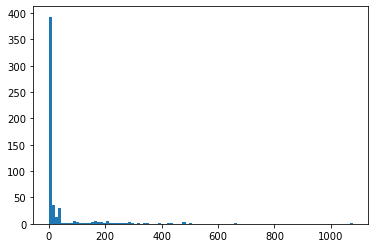

In [8]:
import matplotlib.pyplot as plt
plt.hist(candidate_hit_rank, bins=100)

In [ ]:
hit, total = 0, 0
for (o, t), c in Counter(test_pairs).most_common():
    total += 1
    if word_in_sentences.get(o):
        # 74% origin word in wang271k corpus. 310, 414, 0.748792270531401
        # 80% truth word in wang271k corpus. 332, 414, 0.8019323671497585
        # 68% origin word in sighan corpus. 283, 414, 0.6835748792270532
        # 79% truth word in sighan corpus. 329, 414, 0.7946859903381642
        hit += 1
    # else:
    #     print(o, t, c)
hit, total, hit/total

In [ ]:
import json
autodoc_package = json.load(
        open('./faulty_wording_input.json', 'r'))